# Experiments — Fine-tuning (PyTorch + timm)

Этот ноутбук — шаблон для проведения экспериментов по **fine-tuning** двух семейств моделей (ResNet18 и EfficientNet-B0) в соответствии с требованиями проекта. Он включает: 

- фиксацию seed'ов;
- подготовку данных (ImageFolder из `../data/raw/`);
- трансформации и аугментации;
- обучение и валидацию с логированием кривых;
- построение confusion matrix и сравнение моделей;
- сохранение лучших моделей и экспорт в ONNX (шаблон).


In [4]:
import sys, torch, torchvision
import timm
import sklearn, matplotlib
print("Python:", sys.version.splitlines()[0])
print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("timm:", timm.__version__)
print("sklearn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)

Python: 3.13.0 (tags/v3.13.0:60403a5, Oct  7 2024, 09:38:07) [MSC v.1941 64 bit (AMD64)]
PyTorch: 2.9.0+cpu
Torchvision: 0.24.0+cpu
timm: 1.0.21
sklearn: 1.7.2
matplotlib: 3.10.7


In [5]:
# 1) Фиксация seed'ов и основные импорты
import os, random, time
from dataclasses import dataclass
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Фиксация seed'ов
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


In [6]:
# 2) Конфигурация (датакласс) и пути
@dataclass
class Config:
    data_dir: str = '../data/raw'   # ожидаемая структура: data/raw/<class_name>/*.jpg
    img_size: int = 224
    batch_size: int = 16
    num_workers: int = 4
    epochs: int = 12
    lr: float = 3e-4
    weight_decay: float = 1e-4
    seed: int = 42
    output_dir: str = '../../../Downloads'

cfg = Config(data_dir=os.path.join('..','data','raw'),
             img_size=224,
             batch_size=16,
             num_workers=2,
             epochs=8,
             lr=3e-4,
             weight_decay=1e-4,
             seed=42,
             output_dir='../../../Downloads')

os.makedirs(cfg.output_dir, exist_ok=True)
print(cfg)

Config(data_dir='..\\data\\raw', img_size=224, batch_size=16, num_workers=2, epochs=8, lr=0.0003, weight_decay=0.0001, seed=42, output_dir='../../../Downloads')


In [7]:
# 3) Подготовка датасета: трансформации, ImageFolder, split
from torchvision.datasets import ImageFolder

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(cfg.img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(int(cfg.img_size*1.14)),
    transforms.CenterCrop(cfg.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = ImageFolder(cfg.data_dir, transform=train_transforms)
class_to_idx = full_dataset.class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}
print('Classes:', class_to_idx)

# split dataset (80/20)
n = len(full_dataset)
n_val = max(int(0.2 * n), len(class_to_idx))
n_train = n - n_val
train_ds, val_ds = random_split(full_dataset, [n_train, n_val], generator=torch.Generator().manual_seed(cfg.seed))

val_ds.dataset.transform = val_transforms

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

print('Dataset sizes — train:', len(train_ds), 'val:', len(val_ds))

Classes: {'farfalle': 0, 'penne': 1, 'spaghetti': 2}
Dataset sizes — train: 74 val: 18


In [8]:
# 4) Утилиты: обучение, валидация, сохранение кривых
import timm
import copy
import matplotlib.pyplot as plt

def create_model(model_name, num_classes, pretrained=True, freeze_backbone=True):
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
    if freeze_backbone:
        for name, param in model.named_parameters():
            if 'head' not in name and 'classifier' not in name and 'fc' not in name:
                param.requires_grad = False
    return model

def train_one_epoch(model, optimizer, criterion, loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, targets in tqdm(loader, desc='Train', leave=False):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += images.size(0)
    return running_loss / total, correct / total

def validate(model, criterion, loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, targets in tqdm(loader, desc='Val', leave=False):
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += images.size(0)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_targets.extend(targets.cpu().numpy().tolist())
    return running_loss / total, correct / total, all_preds, all_targets

def plot_curves(histories, metric='loss'):
    plt.figure(figsize=(8,5))
    for label, h in histories.items():
        if metric == 'loss':
            plt.plot(h['train_loss'], label=f"{label} train")
            plt.plot(h['val_loss'], label=f"{label} val")
        else:
            plt.plot(h['train_acc'], label=f"{label} train")
            plt.plot(h['val_acc'], label=f"{label} val")
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
# 5) Обучение — определяем модели и запускаем циклы (пример для двух моделей)
num_classes = len(class_to_idx)
models_to_run = [
    {'name':'resnet18', 'timm_name':'resnet18', 'freeze_backbone':True},
    {'name':'efficientnet_b0', 'timm_name':'efficientnet_b0', 'freeze_backbone':True}
]

histories = {}
results = {}

for mcfg in models_to_run:
    print('\n=== Model:', mcfg['name'], '===')
    set_seed(cfg.seed)
    model = create_model(mcfg['timm_name'], num_classes, pretrained=True, freeze_backbone=mcfg['freeze_backbone'])
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

    for epoch in range(cfg.epochs):
        train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, DEVICE)
        val_loss, val_acc, val_preds, val_targets = validate(model, criterion, val_loader, DEVICE)
        scheduler.step()
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        print(f"Epoch {epoch+1}/{cfg.epochs} — train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), f"{mcfg['name']}_best.pth")
    histories[mcfg['name']] = history
    _, val_acc, preds, targets = validate(model, criterion, val_loader, DEVICE)
    results[mcfg['name']] = {'val_acc': val_acc, 'preds': preds, 'targets': targets}
    print('Best val acc:', best_val_acc)


=== Model: resnet18 ===


Epoch 1/8 — train_loss: 1.1180, val_loss: 1.0673, val_acc: 0.3889


Epoch 2/8 — train_loss: 1.0996, val_loss: 1.0768, val_acc: 0.3333


Epoch 3/8 — train_loss: 1.0779, val_loss: 1.0990, val_acc: 0.3333


Epoch 4/8 — train_loss: 1.0608, val_loss: 1.1172, val_acc: 0.2778


Epoch 5/8 — train_loss: 1.0425, val_loss: 1.1318, val_acc: 0.2778


Epoch 6/8 — train_loss: 1.0364, val_loss: 1.1468, val_acc: 0.2778


Epoch 7/8 — train_loss: 1.0415, val_loss: 1.1591, val_acc: 0.2778


Epoch 8/8 — train_loss: 1.0364, val_loss: 1.1619, val_acc: 0.2222


Best val acc: 0.3888888888888889

=== Model: efficientnet_b0 ===


Epoch 1/8 — train_loss: 2.9173, val_loss: 1.8283, val_acc: 0.4444


Epoch 2/8 — train_loss: 0.6368, val_loss: 1.2705, val_acc: 0.5556


Epoch 3/8 — train_loss: 0.1933, val_loss: 1.4777, val_acc: 0.6111


Epoch 4/8 — train_loss: 0.0869, val_loss: 1.3922, val_acc: 0.6667


Epoch 5/8 — train_loss: 0.1042, val_loss: 1.3541, val_acc: 0.6667


Epoch 6/8 — train_loss: 0.0610, val_loss: 1.3371, val_acc: 0.6111


Epoch 7/8 — train_loss: 0.0578, val_loss: 1.3174, val_acc: 0.6111


Epoch 8/8 — train_loss: 0.0360, val_loss: 1.3120, val_acc: 0.6111


Best val acc: 0.6666666666666666


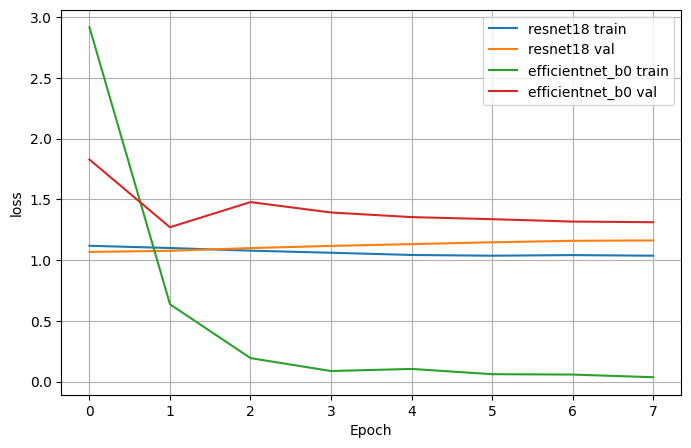

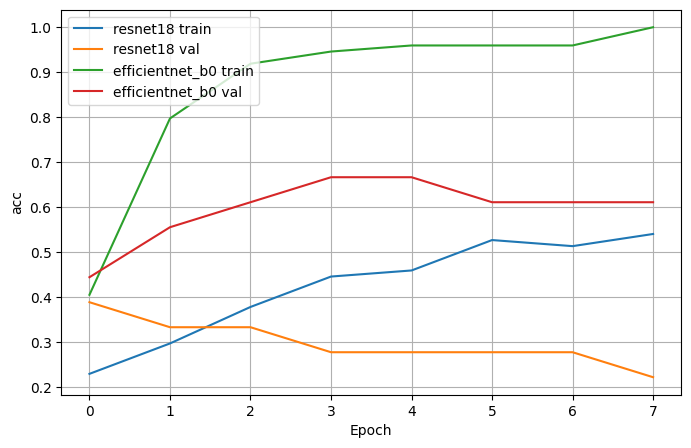

In [10]:
# 6) Построим кривые обучения и матрицы ошибок
plot_curves(histories, metric='loss')
plot_curves(histories, metric='acc')

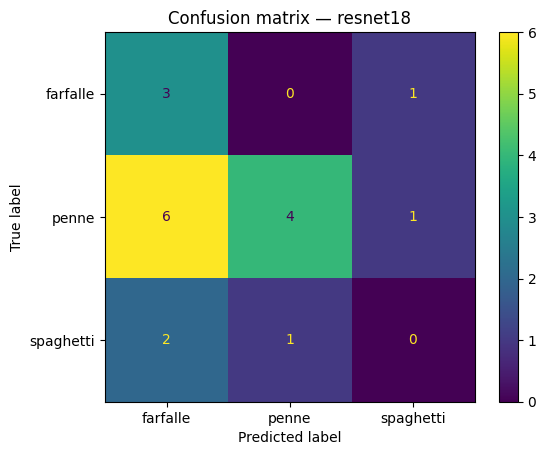

Classification report for resnet18:
               precision    recall  f1-score   support

    farfalle       0.27      0.75      0.40         4
       penne       0.80      0.36      0.50        11
   spaghetti       0.00      0.00      0.00         3

    accuracy                           0.39        18
   macro avg       0.36      0.37      0.30        18
weighted avg       0.55      0.39      0.39        18



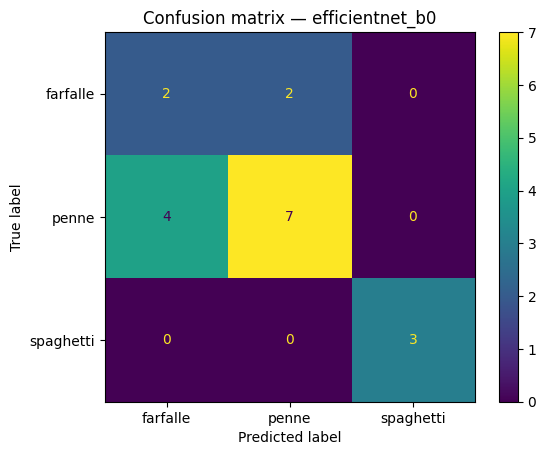

Classification report for efficientnet_b0:
               precision    recall  f1-score   support

    farfalle       0.33      0.50      0.40         4
       penne       0.78      0.64      0.70        11
   spaghetti       1.00      1.00      1.00         3

    accuracy                           0.67        18
   macro avg       0.70      0.71      0.70        18
weighted avg       0.72      0.67      0.68        18



In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

for name, res in results.items():
    cm = confusion_matrix(res['targets'], res['preds'], labels=list(range(num_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx_to_class[i] for i in range(num_classes)])
    disp.plot(values_format='d')
    plt.title(f'Confusion matrix — {name}')
    plt.show()
    print(f"Classification report for {name}:\n", classification_report(res['targets'], res['preds'], target_names=[idx_to_class[i] for i in range(num_classes)]))

In [12]:
# 7) Экспорт лучшей модели в ONNX (пример для первой модели в списке)
# Примечание: перед экспортом убедитесь, что модель находится в режиме eval() и размер входа соответствует ожиданиям.
import torch.onnx as onnx
example_input = torch.randn(1, 3, cfg.img_size, cfg.img_size, device=DEVICE)
first_model_name = models_to_run[0]['name']
pth_path = f"{first_model_name}_best.pth"

# Загружаем архитектуру и веса, затем экспортируем (если требуется)
model = create_model(models_to_run[0]['timm_name'], num_classes, pretrained=False, freeze_backbone=False)
model.load_state_dict(torch.load(pth_path, map_location=DEVICE))
model.eval()
model.to(DEVICE)

onnx_path = f"{first_model_name}_best.onnx"
torch.onnx.export(model, example_input, onnx_path, opset_version=11, input_names=['input'], output_names=['output'], dynamic_axes={'input':{0:'batch_size'}, 'output':{0:'batch_size'}})
print('ONNX saved to', onnx_path)

C:\Users\tvoro\AppData\Local\Temp\ipykernel_5792\1002692983.py:15: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(model, example_input, onnx_path, opset_version=11, input_names=['input'], output_names=['output'], dynamic_axes={'input':{0:'batch_size'}, 'output':{0:'batch_size'}})
W1101 00:28:49.953000 5792 .venv\Lib\site-packages\torch\onnx\_internal\exporter\_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 11).


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


Failed to convert the model to the target version 11 using the ONNX C API. The model was not modified
Traceback (most recent call last):
  File "C:\Users\tvoro\PycharmProjects\Pasta\.venv\Lib\site-packages\onnxscript\version_converter\__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
        func=_partial_convert_version, model=model
    )
  File "C:\Users\tvoro\PycharmProjects\Pasta\.venv\Lib\site-packages\onnxscript\version_converter\_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
  File "C:\Users\tvoro\PycharmProjects\Pasta\.venv\Lib\site-packages\onnxscript\version_converter\__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        proto, target_version=self.target_version
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "C:\Users\tvoro\PycharmProjects\Pasta\.venv\Lib\site-packages\onnx\version_converter.py"

ONNX saved to resnet18_best.onnx


## Заключение

Этот ноутбук — шаблон: он покрывает весь требуемый рабочий процесс экспериментов. После выполнения у тебя появятся:

- файлы с лучшими весами (`*_best.pth`),
- экспортированная ONNX-модель,
- графики обучения и матрицы ошибок.

Если хочешь, я могу дополнительно:
- сгенерировать `README.md` с командами запуска; 
- добавить cell с автоматическим логированием (TensorBoard или Weights & Biases);
- подготовить `app/` так, чтобы оно использовало ровно те же преобразования, что и обучение (чтобы избежать дрейфа).
